In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data.csv', encoding='utf-8')
data

,site,longitude,dimension
0,1,1150,1760
1,2,630,1660
2,3,40,2090
3,4,750,1100
4,5,750,2030
5,6,1030,2070
6,7,1650,650
7,8,1490,1630
8,9,790,2260
9,10,710,1310


In [3]:
data = data.iloc[:, 1:]
data = np.array(data)
data

array([[1150, 1760],
       [ 630, 1660],
       [  40, 2090],
       [ 750, 1100],
       [ 750, 2030],
       [1030, 2070],
       [1650,  650],
       [1490, 1630],
       [ 790, 2260],
       [ 710, 1310],
       [ 840,  550],
       [1170, 2300],
       [ 970, 1340],
       [ 510,  700],
       [ 750,  900],
       [1280, 1200],
       [ 230,  590],
       [ 460,  860],
       [1040,  950],
       [ 590, 1390],
       [ 830, 1770],
       [ 490,  500],
       [1840, 1240],
       [1260, 1500],
       [1280,  790],
       [ 490, 2130],
       [1460, 1420],
       [1260, 1910],
       [ 360, 1980]], dtype=int64)

In [4]:
class TS(object):
    def __init__(self, num_city, data):
        self.taboo_size = 5
        self.iteration = 500
        self.num_city = num_city
        self.location = data
        self.taboo = []

        self.dis_mat = self.compute_dis_mat(num_city, data)
        self.path = self.greedy_init(self.dis_mat, 100, num_city)
        self.best_path = self.path
        self.cur_path = self.path
        self.best_length = self.compute_pathlen(self.path, self.dis_mat)

        # 显示初始化后的路径
        init_pathlen = 1. / self.compute_pathlen(self.path, self.dis_mat)
        # 存储结果
        self.iter_x = [0]
        self.iter_y = [1. / init_pathlen]
    def greedy_init(self, dis_mat, num_total, num_city):
        start_index = 0
        result = []
        for i in range(num_total):
            rest = [x for x in range(0, num_city)]
            # 所有起始点都已经生成了
            if start_index >= num_city:
                start_index = np.random.randint(0, num_city)
                result.append(result[start_index].copy())
                continue
            current = start_index
            rest.remove(current)
            # 找到一条最近邻路径
            result_one = [current]
            while len(rest) != 0:
                tmp_min = math.inf
                tmp_choose = -1
                for x in rest:
                    if dis_mat[current][x] < tmp_min:
                        tmp_min = dis_mat[current][x]
                        tmp_choose = x

                current = tmp_choose
                result_one.append(tmp_choose)
                rest.remove(tmp_choose)
            result.append(result_one)
            start_index += 1
        pathlens = self.compute_paths(result)
        sortindex = np.argsort(pathlens)
        index = sortindex[0]
        return result[index]
        # return result[0]

    # 初始化一条随机路径
    def random_init(self, num_city):
        tmp = [x for x in range(num_city)]
        random.shuffle(tmp)
        return tmp

    # 计算不同城市之间的距离
    def compute_dis_mat(self, num_city, location):
        dis_mat = np.zeros((num_city, num_city))
        for i in range(num_city):
            for j in range(num_city):
                if i == j:
                    dis_mat[i][j] = np.inf
                    continue
                a = location[i]
                b = location[j]
                tmp = np.sqrt(sum([(x[0] - x[1]) ** 2 for x in zip(a, b)]))
                dis_mat[i][j] = tmp
        return dis_mat

    # 计算路径长度
    def compute_pathlen(self, path, dis_mat):
        a = path[0]
        b = path[-1]
        result = dis_mat[a][b]
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            result += dis_mat[a][b]
        return result

    # 计算长度
    def compute_paths(self, paths):
        result = []
        for one in paths:
            length = self.compute_pathlen(one, self.dis_mat)
            result.append(length)
        return result

    # 产生随机解
    def ts_search(self, x):
        moves = []
        new_paths = []
        while len(new_paths)<400:
            i = np.random.randint(len(x))
            j = np.random.randint(len(x))
            tmp = x.copy()
            tmp[i:j] = tmp[i:j][::-1]
            new_paths.append(tmp)
            moves.append([i, j])
        return new_paths, moves

    # 禁忌搜索
    def ts(self):
        for cnt in range(self.iteration):
            new_paths, moves = self.ts_search(self.cur_path)
            new_lengths = self.compute_paths(new_paths)
            sort_index = np.argsort(new_lengths)
            min_l = new_lengths[sort_index[0]]
            min_path = new_paths[sort_index[0]]
            min_move = moves[sort_index[0]]

            # 更新当前的最优路径
            if min_l < self.best_length:
                self.best_length = min_l
                self.best_path = min_path
                self.cur_path = min_path
                # 更新禁忌表
                if min_move in self.taboo:
                    self.taboo.remove(min_move)

                self.taboo.append(min_move)
            else:
                # 找到不在禁忌表中的操作
                while min_move in self.taboo:
                    sort_index = sort_index[1:]
                    min_path = new_paths[sort_index[0]]
                    min_move = moves[sort_index[0]]
                self.cur_path = min_path
                self.taboo.append(min_move)
            # 禁忌表超长了
            if len(self.taboo) > self.taboo_size:
                self.taboo = self.taboo[1:]
            self.iter_x.append(cnt)
            self.iter_y.append(self.best_length)
            # print(cnt, self.best_length)
        # print(self.best_length)
        dd = self.dis_mat[self.best_path[0]][self.best_path[-1]]
        self.best_length += dd
    def run(self):
        self.ts()
        return self.location[self.best_path], self.best_length

In [5]:
model = TS(num_city=data.shape[0], data=data.copy())
Best_path, Best_length = model.run()
print('规划的路径长度:{}'.format(Best_length))
print(Best_path)

规划的路径长度:9497.712390427598
[[1260 1500]
 [1150 1760]
 [ 830 1770]
 [ 630 1660]
 [ 360 1980]
 [  40 2090]
 [ 490 2130]
 [ 750 2030]
 [ 790 2260]
 [1170 2300]
 [1030 2070]
 [1260 1910]
 [1490 1630]
 [1460 1420]
 [1840 1240]
 [1650  650]
 [1280  790]
 [1040  950]
 [ 840  550]
 [ 490  500]
 [ 230  590]
 [ 510  700]
 [ 460  860]
 [ 750  900]
 [ 750 1100]
 [ 590 1390]
 [ 710 1310]
 [ 970 1340]
 [1280 1200]]


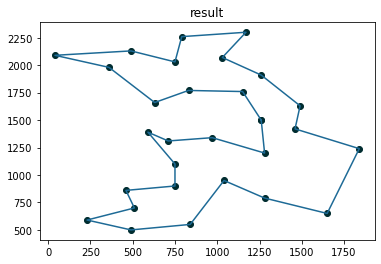

In [7]:
plt.scatter(Best_path[:, 0], Best_path[:, 1], color='#002C2F')
Best_path = np.vstack([Best_path, Best_path[0]])
plt.plot(Best_path[:, 0], Best_path[:, 1], '#1D6A96')
plt.title('result')
plt.savefig('./TS.png', dpi=600)
plt.show()

In [16]:
r = pd.DataFrame(columns=['longitude', 'dimension'], data=Best_path)
b = pd.Series({'Best': Best_length})
a = pd.concat([r, b], axis=1)
a.to_csv('TS.csv', encoding='utf-8', index=False)